In [1]:
!export CUDA_VISIBLE_DEVICES=3

In [2]:
import os
import sys
import argparse
import time
from datetime import datetime
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

from conf.global_settings import *
from utils import (
    get_network,
    get_test_dataloader
)


/home/pzzhao/miniconda3/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


allocated device: cuda:0


In [3]:
args_d = {"net": "resnet101", "gpu":True}
args = argparse.Namespace(**args_d)

In [4]:
model_paths = [
    '/home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/fri1555_16base',
    '/home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/fri2348_16mns',
    '/home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/fri1600_16nmns', 
    '/home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/fri2345_16nms',
    '/home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/tue2_2224_16ep005',
    '/home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/tue2_2226_16ep0025',
    '/home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/wed2_0100_16ep0012',
    '/home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/wed2_0101_16ep0006',
]

In [5]:
models = []
for path in model_paths:
    models.append(get_network(args))

In [6]:
names = []
for idx in range(len(model_paths)):
    path = model_paths[idx]
    name = path.split("/")[-1]
    names.append(name)
    if path[-1] != "/":
        path += "/"
    ckpts = glob.glob(path + "*best.pth")
    ckpts.sort(reverse=True)
    cur_ckpt = ckpts[0]
    print(f"> get cur ckpt {cur_ckpt}")
    checkpoint = torch.load(cur_ckpt)
    models[idx].load_state_dict(checkpoint)

> get cur ckpt /home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/fri1555_16base/resnet101-179-best.pth
> get cur ckpt /home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/fri2348_16mns/resnet101-182-best.pth
> get cur ckpt /home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/fri1600_16nmns/resnet101-177-best.pth
> get cur ckpt /home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/fri2345_16nms/resnet101-177-best.pth
> get cur ckpt /home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/tue2_2224_16ep005/resnet101-192-best.pth
> get cur ckpt /home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/tue2_2226_16ep0025/resnet101-174-best.pth
> get cur ckpt /home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/wed2_0100_16ep0012/resnet101-166-best.pth
> get cur ckpt /home/pzzhao/repos/pytorch-cifar100-practice/checkpoint/resnet101/wed2_0101_16ep0006/resnet101-200-best.pth


In [20]:
k = 1919

img_dir = f"/home/pzzhao/repos/pytorch-cifar100-practice/cifar100_images/"
img_nms = glob.glob(img_dir + f"*.png")
img_nms.sort(key=lambda x: int(x.split("/")[-1].split("_")[0]))
img_sample_nm = img_nms[k]
print(f"get image sample {img_sample_nm}")
img_sample = Image.open(img_sample_nm)

get image sample /home/pzzhao/repos/pytorch-cifar100-practice/cifar100_images/1919_label_26.png


In [21]:
# Define the transformations to apply to the images
mean = CIFAR100_TRAIN_MEAN
std = CIFAR100_TRAIN_STD
transform = transforms.Compose(
    [
    transforms.ToTensor(), 
    transforms.Normalize(mean, std),
    ]
)
img_sample_ts = transform(img_sample).unsqueeze(0)
if args.gpu:
    img_sample_ts = img_sample_ts.cuda()

In [22]:
outs = []
for idx in range(len(models)):
    outs.append(models[idx](img_sample_ts))

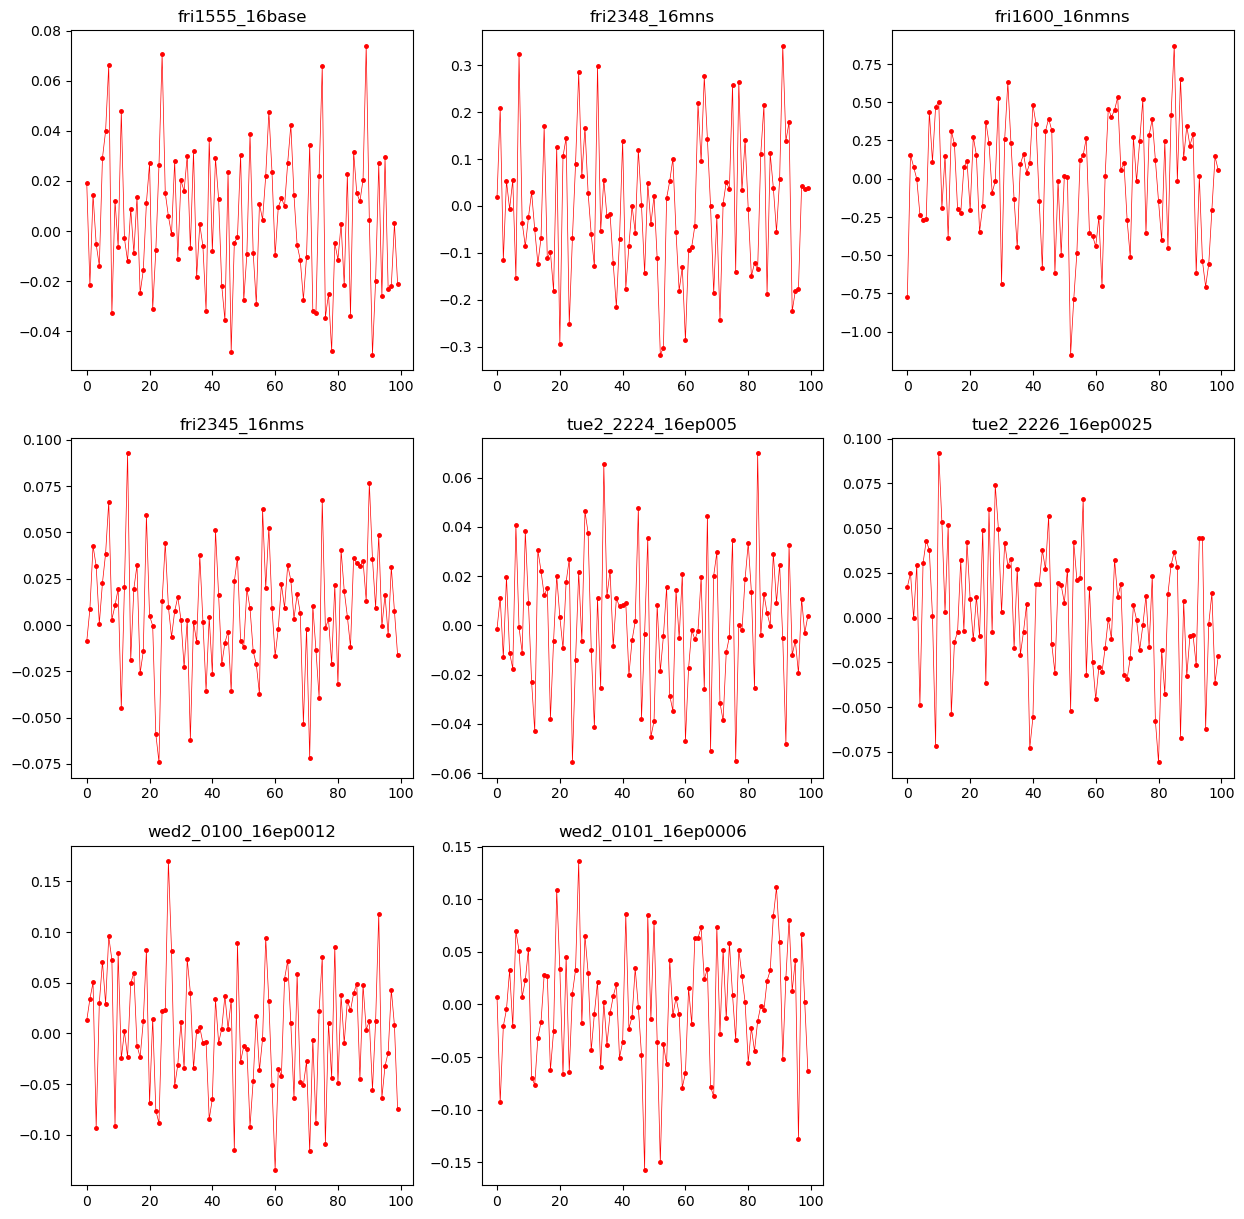

In [24]:
import math
tot_plots = len(outs)
sqrt = math.ceil(math.sqrt(tot_plots))
height = math.ceil(tot_plots / sqrt)

# fig, axes = plt.subplots(nrows=height, ncols=sqrt, figsize=(sqrt*10, height*10))
plt.figure(figsize=(sqrt*5, height*5))
for idx in range(tot_plots):
    plt.subplot(height, sqrt, idx+1)
    cur_arr = outs[idx].squeeze(0).cpu().detach().numpy()
    plt.plot(cur_arr, marker='.', linestyle='-', markersize=5, linewidth=0.5, color="r")
    plt.title(names[idx])
plt.show()

In [11]:

max_avrs = []
others_avrs = []
test_dl = get_test_dataloader(batch_size=64, shuffle=False, mean=mean, std=std)
for model in models:
    cur_max_avr = None
    cur_other_avr = None
    for imgs, labels in test_dl:
        if args.gpu:
            imgs = imgs.cuda()
        cur_out = model(imgs).cpu().detach().numpy()
        cur_part = partitioned_array = np.partition(cur_out, -5)
        cur_max5 = cur_part[:, -5:]
        cur_others = cur_part[:, :-5]
        cur_max5_m = np.mean(cur_max5, axis=1)
        cur_others_m = np.mean(cur_others, axis=1)
        if cur_max_avr is None:
            cur_max_avr = cur_max5_m
        else:
            cur_max_avr = np.concatenate((cur_max_avr, cur_max5_m))
        if cur_other_avr is None:
            cur_other_avr = cur_others_m
        else:
            cur_other_avr = np.concatenate((cur_other_avr, cur_others_m))
        if idx % 2000 == 0:
            print(f"idx {idx}")
    max_avrs.append(np.mean(cur_max_avr))
    others_avrs.append(np.mean(cur_other_avr))


Files already downloaded and verified


In [12]:
for idx in range(len(names)):
    print(f"model: {names[idx]}, avr logit of top-5: {max_avrs[idx]}, rest 95: {others_avrs[idx]}")


model: fri1555_16base, avr logit of top-5: 0.47742393612861633, rest 95: -0.023237138986587524
model: fri2348_16mns, avr logit of top-5: 4.3116774559021, rest 95: -0.2340339869260788
model: fri1600_16nmns, avr logit of top-5: 7.362487316131592, rest 95: -0.3916137218475342
model: fri2345_16nms, avr logit of top-5: 0.48417821526527405, rest 95: -0.02103380486369133
model: tue2_2224_16ep005, avr logit of top-5: 0.656079113483429, rest 95: -0.034624986350536346
model: tue2_2226_16ep0025, avr logit of top-5: 0.8574745059013367, rest 95: -0.04405191168189049
model: wed2_0100_16ep0012, avr logit of top-5: 1.074105978012085, rest 95: -0.05641717463731766
model: wed2_0101_16ep0006, avr logit of top-5: 1.0554473400115967, rest 95: -0.05405786260962486
